# ML Project Example - Image Classification
**Dr. Heba El-Shimy**
### Using Real Waste Dataset
Link: [https://archive.ics.uci.edu/dataset/908/realwaste](https://archive.ics.uci.edu/dataset/908/realwaste)

<a id="toc"></a>

## Steps of a Data Science / Machine Learning Project
Based on content by Andrew Ng - Stanford CS230 2025: [https://youtu.be/MGqQuQEUXhk?si=aRe2kOIUhRCAgeeT](https://youtu.be/MGqQuQEUXhk?si=aRe2kOIUhRCAgeeT)

1. [Specify the problem](#step-1)
2. [Get the data -- Exploratory Data Analysis (EDA)](#step-2)
3. [Design the model](#step-3)
4. [Train the model](#step-4)
5. [Evaluate the model's performance](#step-5)
5. Iterate through steps 2-5 in a rapid development loop
6. Deploy the model (not covered)
7. Monitor / maintain the model (not covered)

<hr height="5px"/>

<a id="step-1"></a>

### Step 1: Specifying the problem

We need to develop a ML model that can detect waste items and classify them into one of 9 classes. This could be implemented in robots that clean waters or beaches.

<hr height="5px"/>

<a id="step-2"></a>

### Step 2: Get the data

We have a dataset from UCI repository: [https://archive.ics.uci.edu/dataset/908/realwaste](https://archive.ics.uci.edu/dataset/908/realwaste)

The dataset has 4,752 images of 9 classes of waste material. Images are colored, captured at the point of reception in a landfill environment. Images in the dataset are of resolution 524x524.

Accompanying publication: [https://www.mdpi.com/2078-2489/14/12/633](https://www.mdpi.com/2078-2489/14/12/633)


**Note:** For simplicity here, I skipped the EDA step, especially that the publication had a detailed analysis of the data.

In [1]:
# Import Libraries
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from collections import Counter
import warnings
warnings.filterwarnings('ignore')

# Deep Learning
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report, matthews_corrcoef,
    roc_curve, auc, roc_auc_score
)
from sklearn.preprocessing import label_binarize
from sklearn.utils.class_weight import compute_class_weight

In [2]:
# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)
tf.debugging.set_log_device_placement(False)

# Display settings
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
%matplotlib inline

In [3]:
# Dataset path
DATA_DIR = 'dataset_cls/RealWaste'

# Image parameters
IMG_SIZE = 224  # Resize from 524x524 to 224x224
BATCH_SIZE = 32
NUM_CLASSES = 9
EPOCHS = 50

# Split ratios
TRAIN_RATIO = 0.70
VAL_RATIO = 0.15
TEST_RATIO = 0.15

print(f"Configuration:")
print(f"  Image Size: {IMG_SIZE}x{IMG_SIZE}")
print(f"  Batch Size: {BATCH_SIZE}")
print(f"  Split: Train={TRAIN_RATIO:.0%}, Val={VAL_RATIO:.0%}, Test={TEST_RATIO:.0%}")

Configuration:
  Image Size: 224x224
  Batch Size: 32
  Split: Train=70%, Val=15%, Test=15%


In [4]:
def load_dataset(data_dir):
    """
    Load all image paths and labels from directory.
    """
    data_dir = Path(data_dir)
    paths, labels, classes = [], [], []
    
    for folder in sorted(data_dir.iterdir()):
        if folder.is_dir():
            classes.append(folder.name)
            for img in folder.glob('*.*'):
                if img.suffix.lower() in ['.jpg', '.jpeg', '.png']:
                    paths.append(str(img))
                    labels.append(folder.name)
    
    return paths, labels, classes

print("Loading dataset...")
all_paths, all_labels, class_names = load_dataset(DATA_DIR)

print(f"Dataset loaded successfully!")
print(f"Total images: {len(all_paths)}")
print(f"Number of classes: {len(class_names)}")
print(f"Classes: {class_names}")

Loading dataset...
Dataset loaded successfully!
Total images: 4752
Number of classes: 9
Classes: ['Cardboard', 'Food Organics', 'Glass', 'Metal', 'Miscellaneous Trash', 'Paper', 'Plastic', 'Textile Trash', 'Vegetation']



Class Distribution:
              Class  Count  Percentage
            Plastic    921   19.381313
              Metal    790   16.624579
              Paper    500   10.521886
Miscellaneous Trash    495   10.416667
          Cardboard    461    9.701178
         Vegetation    436    9.175084
              Glass    420    8.838384
      Food Organics    411    8.648990
      Textile Trash    318    6.691919


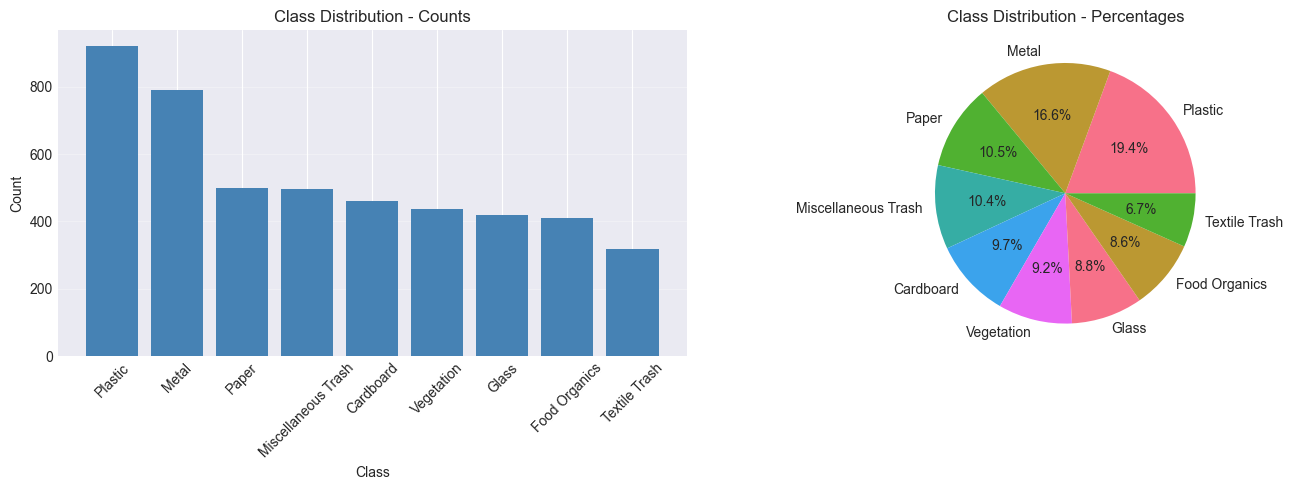

Imbalance ratio: 2.90x
Dataset is imbalanced...Stratification is necessary
We'll use Focal Loss and class weights.


In [5]:
# Analyze class distribution
counts = Counter(all_labels)
df_dist = pd.DataFrame([
    {'Class': c, 'Count': n, 'Percentage': n/len(all_labels)*100}
    for c, n in counts.most_common()
])

print("\nClass Distribution:")
print(df_dist.to_string(index=False))

# Visualize
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

ax1.bar(df_dist['Class'], df_dist['Count'], color='steelblue')
ax1.set_xlabel('Class')
ax1.set_ylabel('Count')
ax1.set_title('Class Distribution - Counts')
ax1.tick_params(axis='x', rotation=45)
ax1.grid(axis='y', alpha=0.3)

ax2.pie(df_dist['Count'], labels=df_dist['Class'], autopct='%1.1f%%')
ax2.set_title('Class Distribution - Percentages')

plt.tight_layout()
plt.show()

# Check imbalance
ratio = df_dist['Count'].max() / df_dist['Count'].min()
print(f"Imbalance ratio: {ratio:.2f}x")

if ratio > 2.0:
    print("Dataset is imbalanced...Stratification is necessary")
    print("We'll use Focal Loss and class weights.")
else:
    print("Dataset is relatively balanced.")

In [6]:
# Step 1: Split off test set (15%)
train_val_paths, test_paths, train_val_labels, test_labels = train_test_split(
    all_paths,
    all_labels,
    test_size=TEST_RATIO,
    stratify=all_labels,
    random_state=42
)

# Step 2: Split train/val (70%/15%)
# To get 70% train and 15% val from original: 15/(70+15) = 0.1765
val_size_adj = VAL_RATIO / (TRAIN_RATIO + VAL_RATIO)

train_paths, val_paths, train_labels, val_labels = train_test_split(
    train_val_paths,
    train_val_labels,
    test_size=val_size_adj,
    stratify=train_val_labels,
    random_state=42
)

print("Data Split Summary:")
print(f"  Total: {len(all_paths)} images")
print(f"  Train: {len(train_paths)} ({len(train_paths)/len(all_paths)*100:.1f}%)")
print(f"  Val: {len(val_paths)} ({len(val_paths)/len(all_paths)*100:.1f}%)")
print(f"  Test: {len(test_paths)} ({len(test_paths)/len(all_paths)*100:.1f}%)")

Data Split Summary:
  Total: 4752 images
  Train: 3326 (70.0%)
  Val: 713 (15.0%)
  Test: 713 (15.0%)


Stratification Verification:
              Class Full% Train%  Val% Test%
          Cardboard  9.70   9.71  9.68  9.68
      Food Organics  8.65   8.63  8.70  8.70
              Glass  8.84   8.84  8.84  8.84
              Metal 16.62  16.63 16.55 16.69
Miscellaneous Trash 10.42  10.43 10.38 10.38
              Paper 10.52  10.52 10.52 10.52
            Plastic 19.38  19.39 19.35 19.35
      Textile Trash  6.69   6.67  6.73  6.73
         Vegetation  9.18   9.17  9.26  9.12


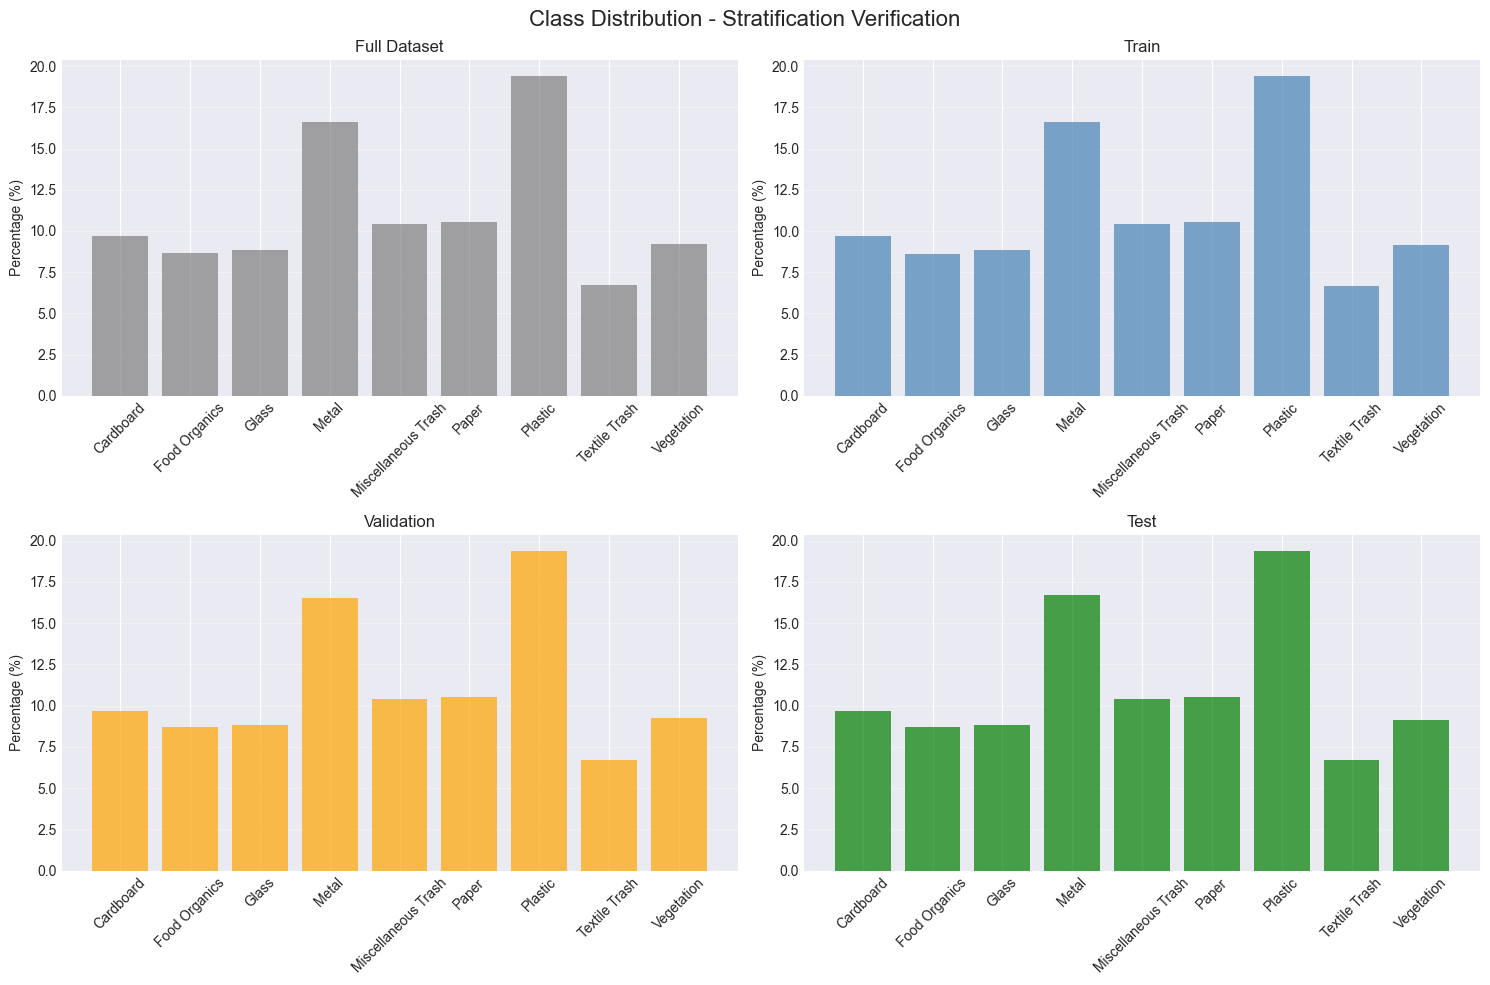

In [7]:
# Get distribution for each split
def get_dist(labels):
    counts = Counter(labels)
    total = len(labels)
    return {c: (n/total)*100 for c, n in counts.items()}

dists = {
    'Full Dataset': get_dist(all_labels),
    'Train': get_dist(train_labels),
    'Validation': get_dist(val_labels),
    'Test': get_dist(test_labels)
}

# Create comparison table
rows = []
for c in sorted(class_names):
    rows.append({
        'Class': c,
        'Full%': f"{dists['Full Dataset'][c]:.2f}",
        'Train%': f"{dists['Train'][c]:.2f}",
        'Val%': f"{dists['Validation'][c]:.2f}",
        'Test%': f"{dists['Test'][c]:.2f}"
    })

print("Stratification Verification:")
print(pd.DataFrame(rows).to_string(index=False))

# Visual verification
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle('Class Distribution - Stratification Verification', fontsize=16)

colors = ['gray', 'steelblue', 'orange', 'green']
for ax, (name, dist), color in zip(axes.flat, dists.items(), colors):
    ax.bar(class_names, [dist[c] for c in class_names], color=color, alpha=0.7)
    ax.set_title(name)
    ax.set_ylabel('Percentage (%)')
    ax.tick_params(axis='x', rotation=45)
    ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

#### Handle Imbalanced Data

Two approaches:
1. **Class Weights** - For moderate imbalance (2-5x ratio)
2. **Focal Loss** - For severe imbalance (>5x ratio)

We'll implement both and compare!

In [8]:
# Compute class weights
label_to_idx = {l: i for i, l in enumerate(sorted(set(all_labels)))}
train_labels_int = [label_to_idx[l] for l in train_labels]

weights_array = compute_class_weight(
    'balanced',
    classes=np.unique(train_labels_int),
    y=train_labels_int
)

class_weights = {i: w for i, w in enumerate(weights_array)}

print("Class Weights:")
for label, idx in sorted(label_to_idx.items()):
    print(f"  {label}: {class_weights[idx]:.3f}")

Class Weights:
  Cardboard: 1.144
  Food Organics: 1.288
  Glass: 1.257
  Metal: 0.668
  Miscellaneous Trash: 1.065
  Paper: 1.056
  Plastic: 0.573
  Textile Trash: 1.665
  Vegetation: 1.212


In [9]:
# Focal Loss Implementation
class FocalLoss(keras.losses.Loss):
    """
    Focal Loss for addressing class imbalance.
    
    FL(pt) = -alpha * (1-pt)^gamma * log(pt)
    
    Args:
        alpha: Weighting factor in [0, 1] (default: 0.25)
        gamma: Focusing parameter >= 0 (default: 2.0)
    """
    def __init__(self, alpha=0.25, gamma=2.0, **kwargs):
        super().__init__(**kwargs)
        self.alpha = alpha
        self.gamma = gamma
    
    def call(self, y_true, y_pred):
        # Clip predictions to prevent log(0)
        y_pred = tf.clip_by_value(y_pred, 1e-7, 1 - 1e-7)
        
        # Calculate cross-entropy
        cross_entropy = -y_true * tf.math.log(y_pred)
        
        # Calculate focal weight
        focal_weight = self.alpha * tf.pow(1 - y_pred, self.gamma)
        
        # Calculate focal loss
        focal_loss = focal_weight * cross_entropy
        
        return tf.reduce_sum(focal_loss, axis=-1)
    
    def get_config(self):
        config = super().get_config()
        config.update({'alpha': self.alpha, 'gamma': self.gamma})
        return config

In [10]:
# Create data generators
# Training set augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    zoom_range=0.1
)

# Val/Test: no augmentation (only rescaling)
val_test_datagen = ImageDataGenerator(rescale=1./255)

# Create DataFrames
train_df = pd.DataFrame({'path': train_paths, 'label': train_labels})
val_df = pd.DataFrame({'path': val_paths, 'label': val_labels})
test_df = pd.DataFrame({'path': test_paths, 'label': test_labels})

# Create generators
train_gen = train_datagen.flow_from_dataframe(
    train_df,
    x_col='path',
    y_col='label',
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True,
    seed=42
)

val_gen = val_test_datagen.flow_from_dataframe(
    val_df,
    x_col='path',
    y_col='label',
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False,
    seed=42
)

test_gen = val_test_datagen.flow_from_dataframe(
    test_df,
    x_col='path',
    y_col='label',
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False,
    seed=42
)

print(f"  Train batches: {len(train_gen)}")
print(f"  Val batches: {len(val_gen)}")
print(f"  Test batches: {len(test_gen)}")
print(f"  Class indices: {train_gen.class_indices}")

Found 3326 validated image filenames belonging to 9 classes.
Found 713 validated image filenames belonging to 9 classes.
Found 713 validated image filenames belonging to 9 classes.
  Train batches: 104
  Val batches: 23
  Test batches: 23
  Class indices: {'Cardboard': 0, 'Food Organics': 1, 'Glass': 2, 'Metal': 3, 'Miscellaneous Trash': 4, 'Paper': 5, 'Plastic': 6, 'Textile Trash': 7, 'Vegetation': 8}


<a id="step-3"></a>

### Step 3: Design the Models

In [11]:
def create_simple_cnn(lr=0.001, dropout=0.3, use_focal=False):
    """
    Simple CNN with 3 convolutional layers.
    """
    model = models.Sequential([
        layers.Conv2D(32, 3, activation='relu', 
                     input_shape=(IMG_SIZE, IMG_SIZE, 3)),
        layers.MaxPooling2D(2),
        
        layers.Conv2D(64, 3, activation='relu'),
        layers.MaxPooling2D(2),
        
        layers.Conv2D(128, 3, activation='relu'),
        layers.MaxPooling2D(2),
        
        layers.Flatten(),
        layers.Dense(256, activation='relu'),
        layers.Dropout(dropout),
        layers.Dense(NUM_CLASSES, activation='softmax')
    ])
    
    loss = FocalLoss() if use_focal else 'categorical_crossentropy'
    loss_name = "Focal Loss" if use_focal else "Categorical Cross-Entropy"
    
    model.compile(
        optimizer=keras.optimizers.Adam(lr),
        loss=loss,
        metrics=['accuracy']
    )
    
    print(f"  Loss function: {loss_name}")
    return model

In [12]:
def create_resnet(freeze=True, lr=0.0001, weights=None):
    """
    ResNet50 with possibility of using transfer learning.
    """
    base = ResNet50(
        include_top=False,
        weights=weights,
        input_shape=(IMG_SIZE, IMG_SIZE, 3)
    )
    
    if freeze:
        # Freeze all layers except last 20
        for layer in base.layers[:-20]:
            layer.trainable = False
    
    model = models.Sequential([
        base,
        layers.GlobalAveragePooling2D(),
        layers.Dense(256, activation='relu'),
        layers.Dropout(0.3),
        layers.Dense(NUM_CLASSES, activation='softmax')
    ])
    
    model.compile(
        optimizer=keras.optimizers.Adam(lr),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    
    trainable = sum([tf.size(w).numpy() for w in model.trainable_weights])
    print(f"  Trainable parameters: {trainable:,}")
    
    return model

In [13]:
# Training callbacks
def get_callbacks():
    return [
        EarlyStopping(
            monitor='val_loss',
            patience=10,
            restore_best_weights=True,
            verbose=1
        ),
        ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.5,
            patience=5,
            min_lr=1e-7,
            verbose=1
        )
    ]

# Storage for results
results = {}
histories = {}

<a id="step-4"></a>

### Step 4: Train the Models

| Exp # | Architecture | Strategy | Loss Function |
|-------|-------------|----------|---------------|
| 1 | Simple CNN | Baseline | Cross-Entropy |
| 2 | Simple CNN | Focal Loss | Focal Loss  |
| 3 | ResNet50 | From Scratch | Cross-Entropy |
| 4 | ResNet50 | Transfer | Cross-Entropy |
| 5 | ResNet50 | Fine-tune | Cross-Entropy |

In [14]:
# Experiment 1: Simple CNN (Baseline)
print("="*60)
print("EXPERIMENT 1: Simple CNN - Baseline")
print("="*60)

model_exp1 = create_simple_cnn(lr=0.001, use_focal=False)

hist_exp1 = model_exp1.fit(
    train_gen,
    validation_data=val_gen,
    epochs=EPOCHS,
    callbacks=get_callbacks(),
    verbose=1
)

histories['Exp1_SimpleCNN_Baseline'] = hist_exp1
results['Exp1_SimpleCNN_Baseline'] = model_exp1

print("Training for Experiment 1 completed!")

EXPERIMENT 1: Simple CNN - Baseline
  Loss function: Categorical Cross-Entropy


2025-10-29 22:45:08.775738: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M4 Max
2025-10-29 22:45:08.775779: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 64.00 GB
2025-10-29 22:45:08.775786: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 24.00 GB
2025-10-29 22:45:08.775810: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-10-29 22:45:08.775823: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Epoch 1/50


2025-10-29 22:45:09.366768: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


104/104 ━━━━━━━━━━━━━━━━━━━━ 14s 129ms/step - accuracy: 0.2288 - loss: 2.3507 - val_accuracy: 0.3212 - val_loss: 1.8625 - learning_rate: 0.0010
Epoch 2/50
104/104 ━━━━━━━━━━━━━━━━━━━━ 13s 129ms/step - accuracy: 0.3130 - loss: 1.8991 - val_accuracy: 0.4025 - val_loss: 1.7115 - learning_rate: 0.0010
Epoch 3/50
104/104 ━━━━━━━━━━━━━━━━━━━━ 14s 130ms/step - accuracy: 0.3554 - loss: 1.8399 - val_accuracy: 0.4600 - val_loss: 1.5970 - learning_rate: 0.0010
Epoch 4/50
104/104 ━━━━━━━━━━━━━━━━━━━━ 14s 130ms/step - accuracy: 0.3746 - loss: 1.8739 - val_accuracy: 0.4951 - val_loss: 1.5709 - learning_rate: 0.0010
Epoch 5/50
104/104 ━━━━━━━━━━━━━━━━━━━━ 14s 130ms/step - accuracy: 0.3794 - loss: 1.9446 - val_accuracy: 0.5161 - val_loss: 1.5140 - learning_rate: 0.0010
Epoch 6/50
104/104 ━━━━━━━━━━━━━━━━━━━━ 14s 130ms/step - accuracy: 0.3909 - loss: 1.9743 - val_accuracy: 0.4867 - val_loss: 1.7502 - learning_rate: 0.0010
Epoch 7/50
104/104 ━━━━━━━━━━━━━━━━━━━━ 14s 130ms/step - accuracy: 0.3930 - loss:

In [15]:
# Experiment 2: Simple CNN with Focal Loss
print("="*60)
print("EXPERIMENT 2: Simple CNN - Focal Loss")
print("="*60)

model_exp2 = create_simple_cnn(lr=0.001, use_focal=True)

hist_exp2 = model_exp2.fit(
    train_gen,
    validation_data=val_gen,
    epochs=EPOCHS,
    class_weight=class_weights,
    callbacks=get_callbacks(),
    verbose=1
)

histories['Exp2_SimpleCNN_Focal'] = hist_exp2
results['Exp2_SimpleCNN_Focal'] = model_exp2

print("Training for Experiment 2 completed!")

EXPERIMENT 2: Simple CNN - Focal Loss
  Loss function: Focal Loss
Epoch 1/50
104/104 ━━━━━━━━━━━━━━━━━━━━ 14s 129ms/step - accuracy: 0.1957 - loss: 0.4785 - val_accuracy: 0.2440 - val_loss: 0.4285 - learning_rate: 0.0010
Epoch 2/50
104/104 ━━━━━━━━━━━━━━━━━━━━ 14s 130ms/step - accuracy: 0.3046 - loss: 0.3568 - val_accuracy: 0.3927 - val_loss: 0.3231 - learning_rate: 0.0010
Epoch 3/50
104/104 ━━━━━━━━━━━━━━━━━━━━ 14s 130ms/step - accuracy: 0.3400 - loss: 0.3391 - val_accuracy: 0.4348 - val_loss: 0.3827 - learning_rate: 0.0010
Epoch 4/50
104/104 ━━━━━━━━━━━━━━━━━━━━ 14s 130ms/step - accuracy: 0.3355 - loss: 0.3865 - val_accuracy: 0.4095 - val_loss: 0.3308 - learning_rate: 0.0010
Epoch 5/50
104/104 ━━━━━━━━━━━━━━━━━━━━ 14s 130ms/step - accuracy: 0.3674 - loss: 0.3440 - val_accuracy: 0.4095 - val_loss: 0.3332 - learning_rate: 0.0010
Epoch 6/50
104/104 ━━━━━━━━━━━━━━━━━━━━ 14s 130ms/step - accuracy: 0.3818 - loss: 0.3846 - val_accuracy: 0.4474 - val_loss: 0.2946 - learning_rate: 0.0010
Epoc

In [16]:
# Experiment 3: ResNet50 Train from Scratch
print("="*60)
print("EXPERIMENT 3: ResNet50 - Train from Scratch")
print("="*60)

model_exp3 = create_resnet(freeze=False, lr=0.001, weights=None)

hist_exp3 = model_exp3.fit(
    train_gen,
    validation_data=val_gen,
    epochs=EPOCHS,
    callbacks=get_callbacks(),
    verbose=1
)

histories['Exp3_ResNet'] = hist_exp3
results['Exp3_ResNet'] = model_exp3

print("Training for Experiment 3 completed!")

EXPERIMENT 3: ResNet50 - Train from Scratch
  Trainable parameters: 24,061,449
Epoch 1/50
104/104 ━━━━━━━━━━━━━━━━━━━━ 54s 335ms/step - accuracy: 0.2135 - loss: 4.8981 - val_accuracy: 0.0884 - val_loss: 3.5879 - learning_rate: 0.0010
Epoch 2/50
104/104 ━━━━━━━━━━━━━━━━━━━━ 31s 300ms/step - accuracy: 0.2432 - loss: 4.3158 - val_accuracy: 0.2020 - val_loss: 32.2682 - learning_rate: 0.0010
Epoch 3/50
104/104 ━━━━━━━━━━━━━━━━━━━━ 35s 339ms/step - accuracy: 0.2799 - loss: 4.4119 - val_accuracy: 0.1038 - val_loss: 9.4991 - learning_rate: 0.0010
Epoch 4/50
104/104 ━━━━━━━━━━━━━━━━━━━━ 35s 339ms/step - accuracy: 0.3007 - loss: 3.9269 - val_accuracy: 0.2216 - val_loss: 5.5928 - learning_rate: 0.0010
Epoch 5/50
104/104 ━━━━━━━━━━━━━━━━━━━━ 49s 474ms/step - accuracy: 0.3184 - loss: 3.5364 - val_accuracy: 0.4053 - val_loss: 2.3418 - learning_rate: 0.0010
Epoch 6/50
104/104 ━━━━━━━━━━━━━━━━━━━━ 65s 621ms/step - accuracy: 0.3331 - loss: 3.5907 - val_accuracy: 0.1669 - val_loss: 6.8941 - learning_rat

104/104 ━━━━━━━━━━━━━━━━━━━━ 48s 459ms/step - accuracy: 0.5713 - loss: 1.3569 - val_accuracy: 0.6536 - val_loss: 1.1258 - learning_rate: 6.2500e-05
Epoch 39/50
104/104 ━━━━━━━━━━━━━━━━━━━━ 46s 446ms/step - accuracy: 0.5815 - loss: 1.3472 - val_accuracy: 0.5961 - val_loss: 1.4625 - learning_rate: 6.2500e-05
Epoch 40/50
104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 428ms/step - accuracy: 0.6005 - loss: 1.3144
Epoch 40: ReduceLROnPlateau reducing learning rate to 3.125000148429535e-05.
104/104 ━━━━━━━━━━━━━━━━━━━━ 46s 446ms/step - accuracy: 0.5851 - loss: 1.3388 - val_accuracy: 0.6367 - val_loss: 1.2590 - learning_rate: 6.2500e-05
Epoch 41/50
104/104 ━━━━━━━━━━━━━━━━━━━━ 45s 433ms/step - accuracy: 0.6143 - loss: 1.2672 - val_accuracy: 0.5919 - val_loss: 1.3422 - learning_rate: 3.1250e-05
Epoch 42/50
104/104 ━━━━━━━━━━━━━━━━━━━━ 45s 432ms/step - accuracy: 0.6058 - loss: 1.2741 - val_accuracy: 0.6424 - val_loss: 1.2644 - learning_rate: 3.1250e-05
Epoch 43/50
104/104 ━━━━━━━━━━━━━━━━━━━━ 45s 430ms/step - 

In [17]:
# Experiment 4: ResNet50 Transfer Learning
print("="*60)
print("EXPERIMENT 4: ResNet50 - Transfer Learning")
print("="*60)

model_exp4 = create_resnet(freeze=True, lr=0.0001, weights='imagenet')

hist_exp4 = model_exp4.fit(
    train_gen,
    validation_data=val_gen,
    epochs=EPOCHS,
    callbacks=get_callbacks(),
    verbose=1
)

histories['Exp4_ResNet_Transfer'] = hist_exp4
results['Exp4_ResNet_Transfer'] = model_exp4

print("Training for Experiment 4 completed!")

EXPERIMENT 4: ResNet50 - Transfer Learning
  Trainable parameters: 9,458,185
Epoch 1/50
104/104 ━━━━━━━━━━━━━━━━━━━━ 22s 175ms/step - accuracy: 0.2962 - loss: 1.8980 - val_accuracy: 0.2020 - val_loss: 2.2181 - learning_rate: 1.0000e-04
Epoch 2/50
104/104 ━━━━━━━━━━━━━━━━━━━━ 15s 148ms/step - accuracy: 0.3479 - loss: 1.7479 - val_accuracy: 0.2721 - val_loss: 2.0510 - learning_rate: 1.0000e-04
Epoch 3/50
104/104 ━━━━━━━━━━━━━━━━━━━━ 16s 150ms/step - accuracy: 0.3924 - loss: 1.7026 - val_accuracy: 0.3212 - val_loss: 1.8679 - learning_rate: 1.0000e-04
Epoch 4/50
104/104 ━━━━━━━━━━━━━━━━━━━━ 16s 150ms/step - accuracy: 0.4140 - loss: 1.6227 - val_accuracy: 0.4502 - val_loss: 1.5481 - learning_rate: 1.0000e-04
Epoch 5/50
104/104 ━━━━━━━━━━━━━━━━━━━━ 15s 147ms/step - accuracy: 0.4116 - loss: 1.6217 - val_accuracy: 0.3086 - val_loss: 2.3029 - learning_rate: 1.0000e-04
Epoch 6/50
104/104 ━━━━━━━━━━━━━━━━━━━━ 15s 147ms/step - accuracy: 0.4149 - loss: 1.6087 - val_accuracy: 0.4025 - val_loss: 1.69

104/104 ━━━━━━━━━━━━━━━━━━━━ 16s 152ms/step - accuracy: 0.6332 - loss: 1.0310 - val_accuracy: 0.5428 - val_loss: 1.3055 - learning_rate: 1.2500e-05
Epoch 40/50
104/104 ━━━━━━━━━━━━━━━━━━━━ 16s 157ms/step - accuracy: 0.6452 - loss: 1.0389 - val_accuracy: 0.5792 - val_loss: 1.1616 - learning_rate: 1.2500e-05
Epoch 41/50
104/104 ━━━━━━━━━━━━━━━━━━━━ 16s 153ms/step - accuracy: 0.6455 - loss: 1.0003 - val_accuracy: 0.5021 - val_loss: 1.5545 - learning_rate: 1.2500e-05
Epoch 42/50
104/104 ━━━━━━━━━━━━━━━━━━━━ 16s 152ms/step - accuracy: 0.6365 - loss: 1.0031 - val_accuracy: 0.6003 - val_loss: 1.1924 - learning_rate: 1.2500e-05
Epoch 43/50
104/104 ━━━━━━━━━━━━━━━━━━━━ 16s 151ms/step - accuracy: 0.6377 - loss: 1.0255 - val_accuracy: 0.5849 - val_loss: 1.2291 - learning_rate: 1.2500e-05
Epoch 44/50
104/104 ━━━━━━━━━━━━━━━━━━━━ 16s 149ms/step - accuracy: 0.6473 - loss: 1.0066 - val_accuracy: 0.5666 - val_loss: 1.2278 - learning_rate: 1.2500e-05
Epoch 45/50
104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/st

In [18]:
# Experiment 5: ResNet50 Fine-tuning
print("="*60)
print("EXPERIMENT 5: ResNet50 - Fine-tuning")
print("="*60)

model_exp5 = create_resnet(freeze=False, lr=0.0001, weights='imagenet')

hist_exp5 = model_exp5.fit(
    train_gen,
    validation_data=val_gen,
    epochs=EPOCHS,
    callbacks=get_callbacks(),
    verbose=1
)

histories['Exp5_ResNet_Finetune'] = hist_exp5
results['Exp5_ResNet_Finetune'] = model_exp5

print("Training for Experiment 5 completed!")
print("="*60)
print("ALL EXPERIMENTS COMPLETED!")
print("="*60)

EXPERIMENT 5: ResNet50 - Fine-tuning
  Trainable parameters: 24,061,449
Epoch 1/50
104/104 ━━━━━━━━━━━━━━━━━━━━ 67s 441ms/step - accuracy: 0.6431 - loss: 1.1059 - val_accuracy: 0.0968 - val_loss: 4.9775 - learning_rate: 1.0000e-04
Epoch 2/50
104/104 ━━━━━━━━━━━━━━━━━━━━ 36s 347ms/step - accuracy: 0.8434 - loss: 0.4626 - val_accuracy: 0.0968 - val_loss: 14.6331 - learning_rate: 1.0000e-04
Epoch 3/50
104/104 ━━━━━━━━━━━━━━━━━━━━ 38s 369ms/step - accuracy: 0.9029 - loss: 0.3046 - val_accuracy: 0.1655 - val_loss: 8.7791 - learning_rate: 1.0000e-04
Epoch 4/50
104/104 ━━━━━━━━━━━━━━━━━━━━ 41s 392ms/step - accuracy: 0.9281 - loss: 0.2220 - val_accuracy: 0.1655 - val_loss: 13.4143 - learning_rate: 1.0000e-04
Epoch 5/50
104/104 ━━━━━━━━━━━━━━━━━━━━ 44s 421ms/step - accuracy: 0.9495 - loss: 0.1500 - val_accuracy: 0.1557 - val_loss: 14.2011 - learning_rate: 1.0000e-04
Epoch 6/50
104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 420ms/step - accuracy: 0.9437 - loss: 0.1542
Epoch 6: ReduceLROnPlateau reducing learni

104/104 ━━━━━━━━━━━━━━━━━━━━ 47s 454ms/step - accuracy: 0.9991 - loss: 0.0029 - val_accuracy: 0.9313 - val_loss: 0.2988 - learning_rate: 1.2500e-05
Epoch 40/50
104/104 ━━━━━━━━━━━━━━━━━━━━ 50s 478ms/step - accuracy: 0.9994 - loss: 0.0021 - val_accuracy: 0.9285 - val_loss: 0.3192 - learning_rate: 1.2500e-05
Epoch 41/50
104/104 ━━━━━━━━━━━━━━━━━━━━ 51s 488ms/step - accuracy: 0.9994 - loss: 0.0016 - val_accuracy: 0.9144 - val_loss: 0.4159 - learning_rate: 1.2500e-05
Epoch 42/50
104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 433ms/step - accuracy: 1.0000 - loss: 0.0023
Epoch 42: ReduceLROnPlateau reducing learning rate to 6.24999984211172e-06.
104/104 ━━━━━━━━━━━━━━━━━━━━ 47s 454ms/step - accuracy: 1.0000 - loss: 0.0020 - val_accuracy: 0.9285 - val_loss: 0.3471 - learning_rate: 1.2500e-05
Epoch 43/50
104/104 ━━━━━━━━━━━━━━━━━━━━ 46s 442ms/step - accuracy: 0.9997 - loss: 0.0020 - val_accuracy: 0.9215 - val_loss: 0.3635 - learning_rate: 6.2500e-06
Epoch 44/50
104/104 ━━━━━━━━━━━━━━━━━━━━ 45s 436ms/step - a

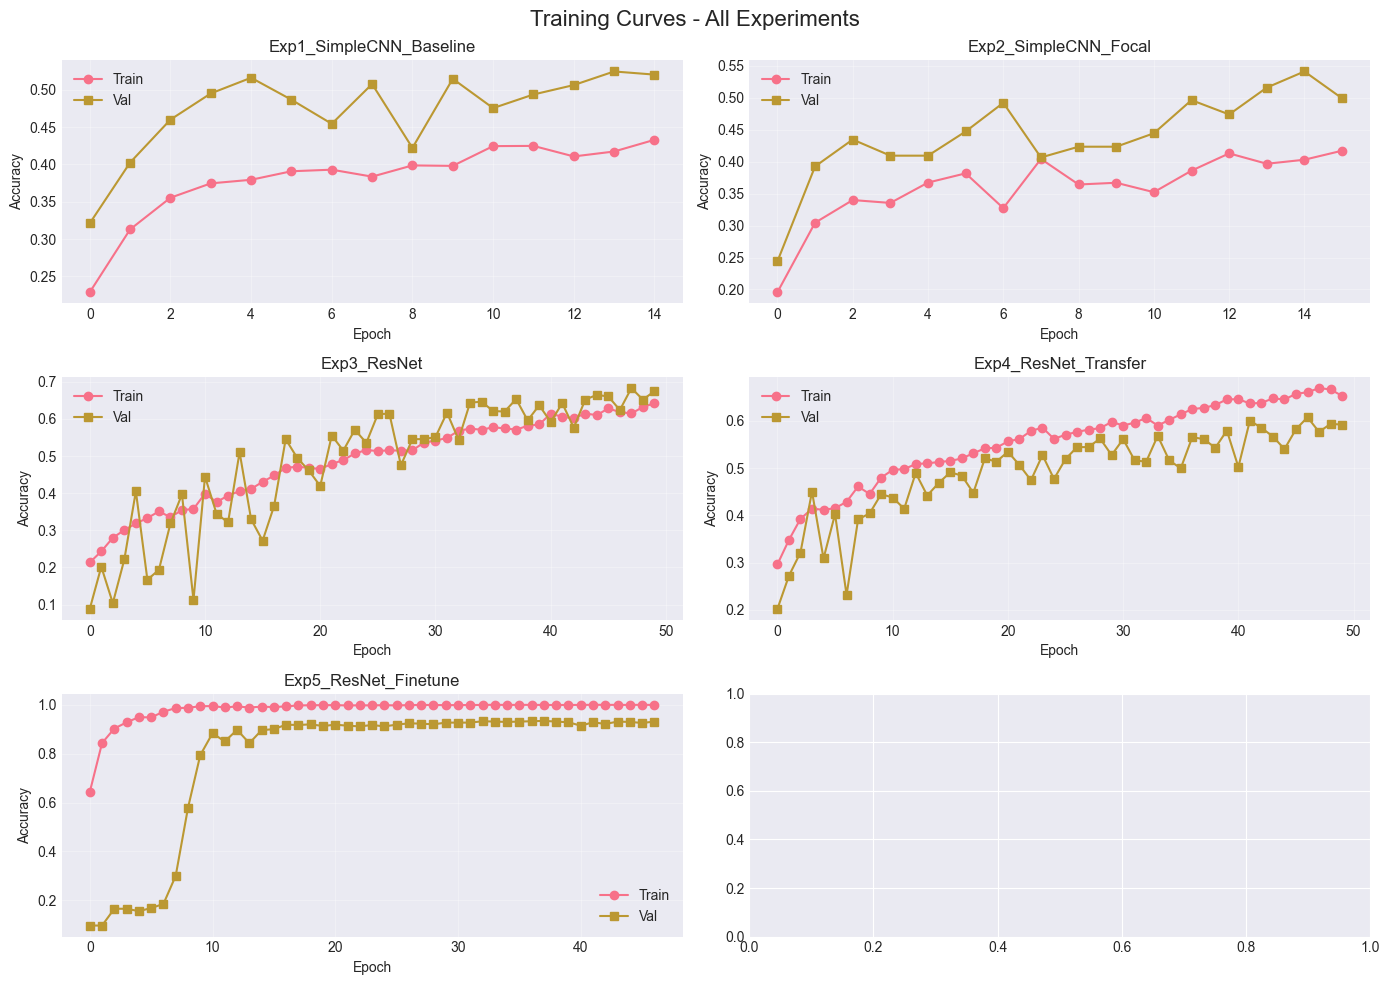

In [20]:
# Plot training curves
fig, axes = plt.subplots(3, 2, figsize=(14, 10))
fig.suptitle('Training Curves - All Experiments', fontsize=16)

for idx, (name, hist) in enumerate(histories.items()):
    ax = axes[idx//2, idx%2]
    ax.plot(hist.history['accuracy'], 'o-', label='Train')
    ax.plot(hist.history['val_accuracy'], 's-', label='Val')
    ax.set_title(name)
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Accuracy')
    ax.legend()
    ax.grid(alpha=0.3)

plt.tight_layout()
plt.show()

<a id="step-5"></a>

### Step 5: Evaluate the Models

In [21]:
def evaluate_with_roc(model, gen, name="Test"):
    """
    Evaluation with ROC/AUC.
    """
    print(f"\nEvaluating on {name} set...")
    gen.reset()
    
    # Get predictions
    y_pred_proba = model.predict(gen, verbose=0)
    y_pred = np.argmax(y_pred_proba, axis=1)
    y_true = gen.classes
    
    # Basic metrics
    metrics = {
        'accuracy': accuracy_score(y_true, y_pred),
        'precision': precision_score(y_true, y_pred, average='weighted', zero_division=0),
        'recall': recall_score(y_true, y_pred, average='weighted', zero_division=0),
        'f1': f1_score(y_true, y_pred, average='weighted', zero_division=0),
        'mcc': matthews_corrcoef(y_true, y_pred),
        'cm': confusion_matrix(y_true, y_pred)
    }
    
    # ROC/AUC - Multi-class (one-vs-rest)
    y_true_bin = label_binarize(y_true, classes=range(NUM_CLASSES))
    
    fpr, tpr, roc_auc = {}, {}, {}
    
    # Per-class ROC
    for i in range(NUM_CLASSES):
        fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_pred_proba[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
    
    # Micro-average ROC
    fpr["micro"], tpr["micro"], _ = roc_curve(
        y_true_bin.ravel(),
        y_pred_proba.ravel()
    )
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
    
    # Macro-average AUC
    roc_auc["macro"] = np.mean([roc_auc[i] for i in range(NUM_CLASSES)])
    
    metrics.update({'fpr': fpr, 'tpr': tpr, 'roc_auc': roc_auc})
    return metrics

In [22]:
# Evaluate all models on validation and test sets
val_metrics = {}
test_metrics = {}

print("="*80)
print("EVALUATING ALL MODELS")
print("="*80)

for name, model in results.items():
    print(f"\n{'='*80}")
    print(f"{name}")
    print(f"{'='*80}")
    
    val_metrics[name] = evaluate_with_roc(model, val_gen, "Validation")
    test_metrics[name] = evaluate_with_roc(model, test_gen, "Test")
    
    print(f"Results:")
    print(f"  Val Accuracy: {val_metrics[name]['accuracy']:.4f}")
    print(f"  Test Accuracy: {test_metrics[name]['accuracy']:.4f}")
    print(f"  Test AUC (macro): {test_metrics[name]['roc_auc']['macro']:.4f}")

EVALUATING ALL MODELS

Exp1_SimpleCNN_Baseline

Evaluating on Validation set...

Evaluating on Test set...
Results:
  Val Accuracy: 0.5161
  Test Accuracy: 0.5147
  Test AUC (macro): 0.8333

Exp2_SimpleCNN_Focal

Evaluating on Validation set...

Evaluating on Test set...
Results:
  Val Accuracy: 0.4474
  Test Accuracy: 0.4334
  Test AUC (macro): 0.8463

Exp3_ResNet

Evaluating on Validation set...

Evaluating on Test set...
Results:
  Val Accuracy: 0.6830
  Test Accuracy: 0.6648
  Test AUC (macro): 0.9398

Exp4_ResNet_Transfer

Evaluating on Validation set...

Evaluating on Test set...
Results:
  Val Accuracy: 0.5933
  Test Accuracy: 0.5568
  Test AUC (macro): 0.9096

Exp5_ResNet_Finetune

Evaluating on Validation set...

Evaluating on Test set...
Results:
  Val Accuracy: 0.9327
  Test Accuracy: 0.9102
  Test AUC (macro): 0.9953


In [23]:
# Create results comparison table
comp_data = []
for name in results.keys():
    comp_data.append({
        'Experiment': name,
        'Val_Acc': val_metrics[name]['accuracy'],
        'Test_Acc': test_metrics[name]['accuracy'],
        'Test_Prec': test_metrics[name]['precision'],
        'Test_Rec': test_metrics[name]['recall'],
        'Test_F1': test_metrics[name]['f1'],
        'Test_MCC': test_metrics[name]['mcc'],
        'Test_AUC': test_metrics[name]['roc_auc']['macro']
    })

results_df = pd.DataFrame(comp_data)

print("="*100)
print("RESULTS COMPARISON")
print("="*100)
print(results_df.to_string(index=False))

RESULTS COMPARISON
             Experiment  Val_Acc  Test_Acc  Test_Prec  Test_Rec  Test_F1  Test_MCC  Test_AUC
Exp1_SimpleCNN_Baseline 0.516129  0.514727   0.473563  0.514727 0.474438  0.446894  0.833267
   Exp2_SimpleCNN_Focal 0.447405  0.433380   0.511444  0.433380 0.402115  0.373687  0.846278
            Exp3_ResNet 0.683029  0.664797   0.671564  0.664797 0.662234  0.617755  0.939760
   Exp4_ResNet_Transfer 0.593268  0.556802   0.567014  0.556802 0.548432  0.493346  0.909575
   Exp5_ResNet_Finetune 0.932679  0.910238   0.911033  0.910238 0.909926  0.897585  0.995265


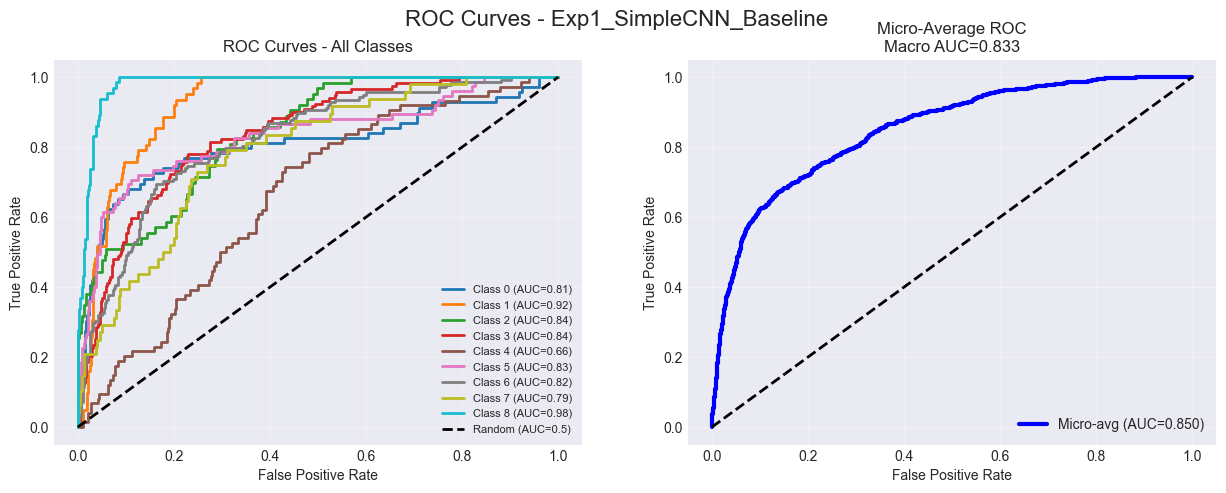

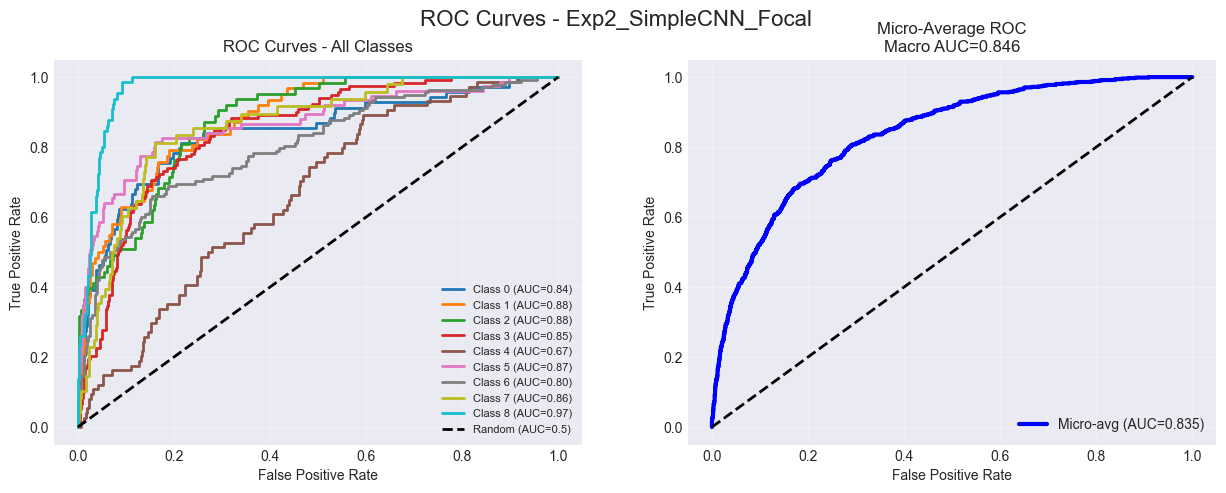

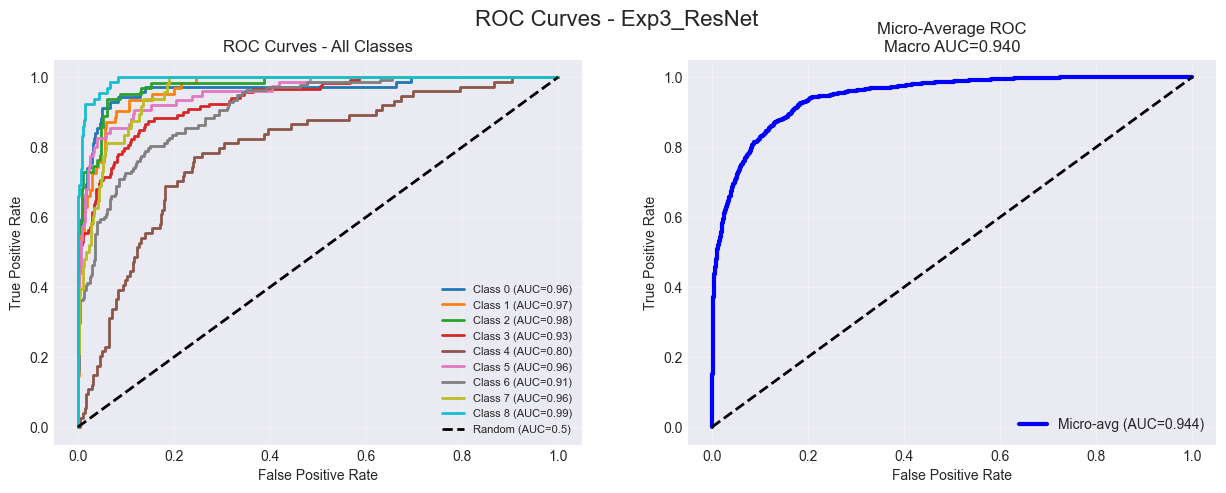

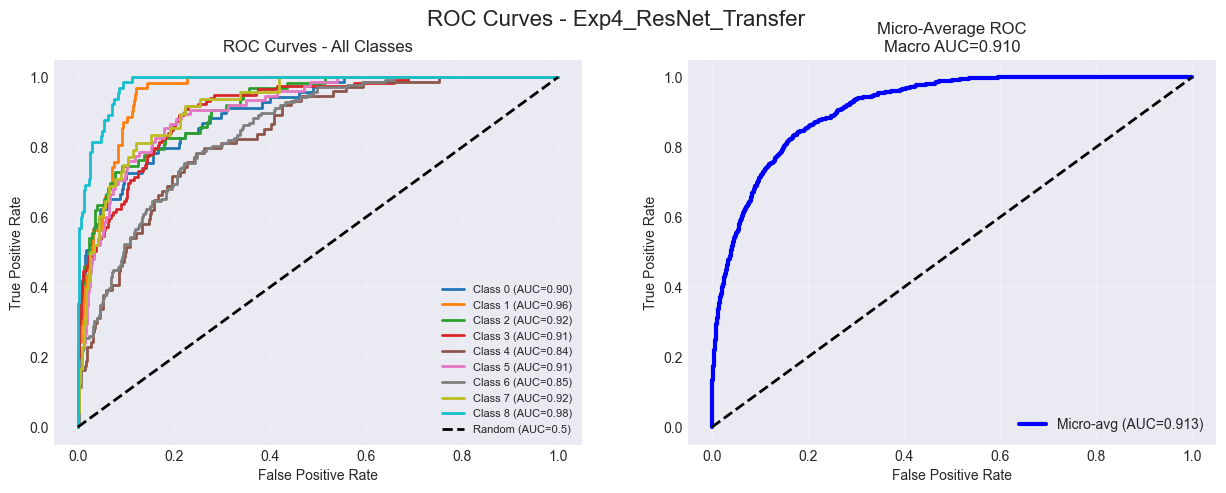

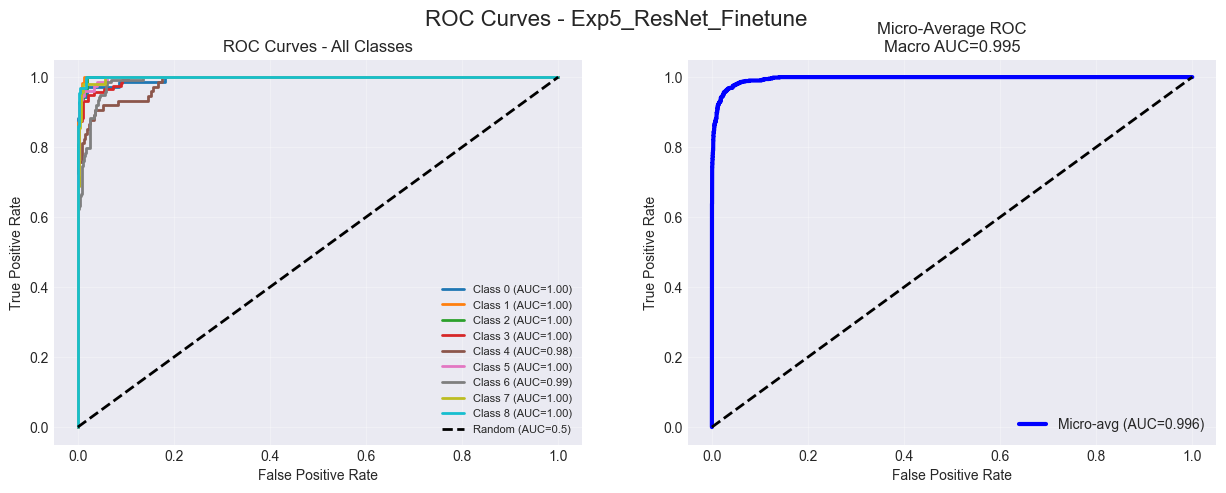

In [34]:
def plot_roc_curves(metrics, exp_name):
    """
    Plot ROC curves.
    """
    fpr, tpr, roc_auc = metrics['fpr'], metrics['tpr'], metrics['roc_auc']
    
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))
    fig.suptitle(f'ROC Curves - {exp_name}', fontsize=16)
    
    # Plot 1: All classes
    ax = axes[0]
    colors = plt.cm.tab10(np.linspace(0, 1, NUM_CLASSES))
    
    for i, color in zip(range(NUM_CLASSES), colors):
        ax.plot(fpr[i], tpr[i], color=color, lw=2,
                label=f'Class {i} (AUC={roc_auc[i]:.2f})')
    
    ax.plot([0, 1], [0, 1], 'k--', lw=2, label='Random (AUC=0.5)')
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title('ROC Curves - All Classes')
    ax.legend(loc='lower right', fontsize=8)
    ax.grid(alpha=0.3)
    
    # Plot 2: Micro-average
    ax = axes[1]
    ax.plot(fpr["micro"], tpr["micro"], 'b-', lw=3,
            label=f'Micro-avg (AUC={roc_auc["micro"]:.3f})')
    ax.plot([0, 1], [0, 1], 'k--', lw=2)
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title(f'Micro-Average ROC\nMacro AUC={roc_auc["macro"]:.3f}')
    ax.legend(loc='lower right')
    ax.grid(alpha=0.3)

# Plot ROC curves for all experiments
for name, metrics in test_metrics.items():
    plot_roc_curves(metrics, name)

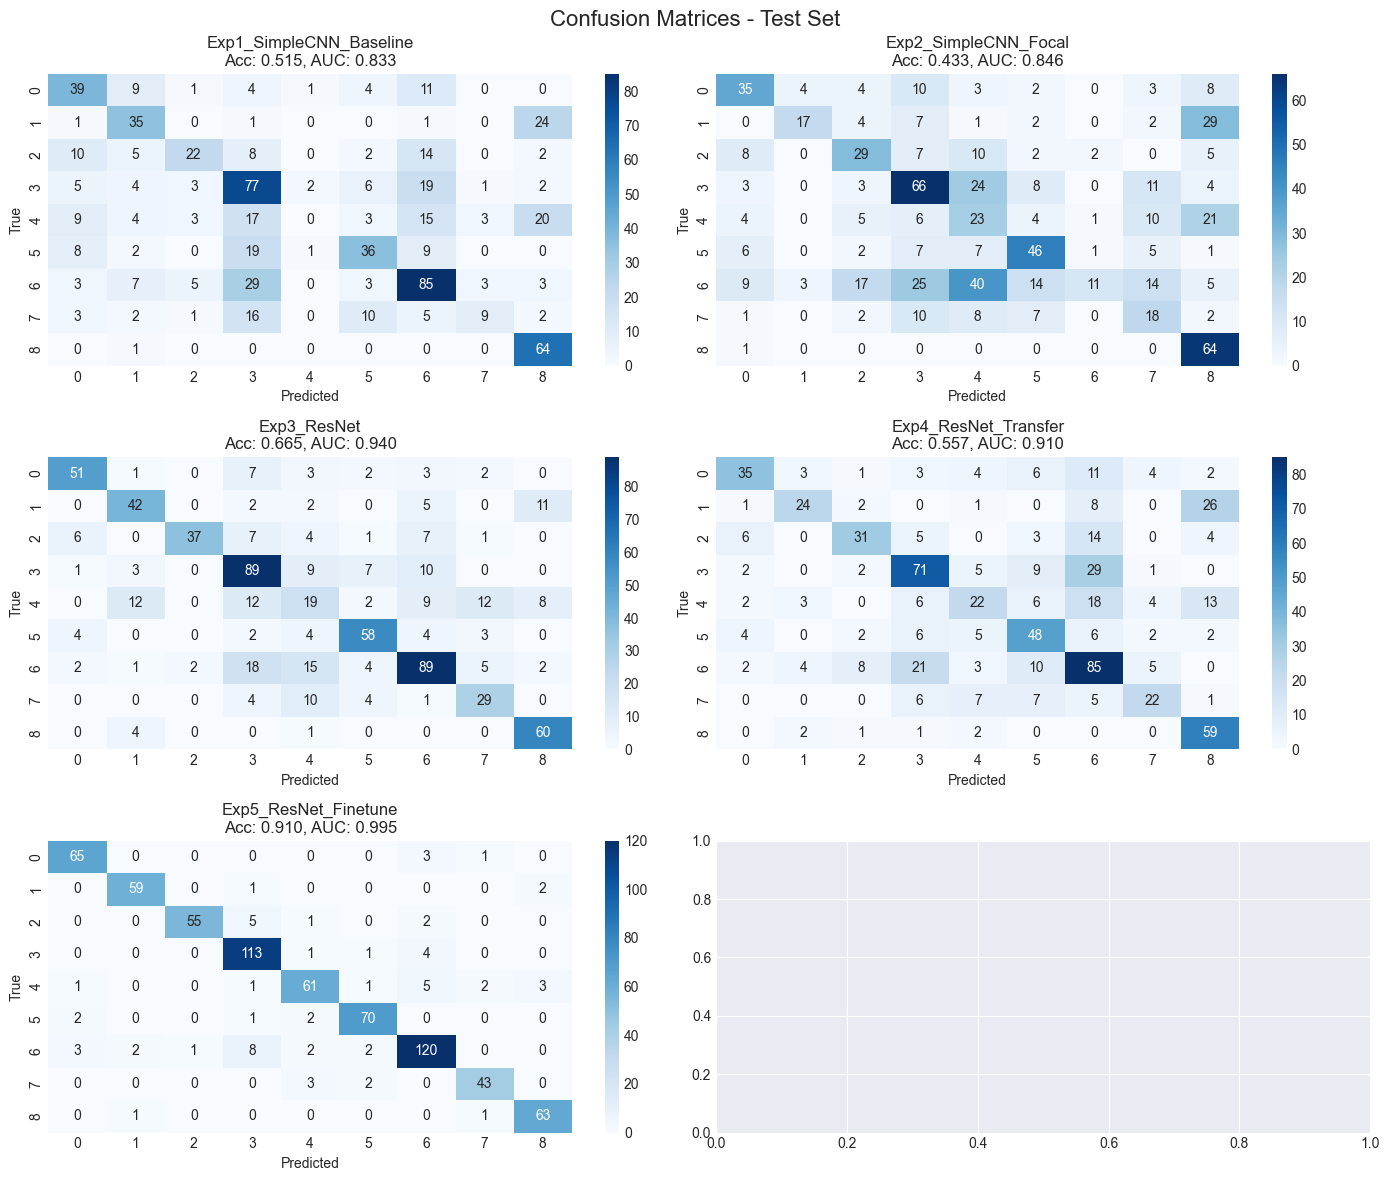

In [37]:
# Confusion Matrices - Test Set
fig, axes = plt.subplots(3, 2, figsize=(14, 12))
fig.suptitle('Confusion Matrices - Test Set', fontsize=16)
axes = axes.flatten()

for idx, (name, metrics) in enumerate(test_metrics.items()):
    cm = metrics['cm']
    
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[idx])
    
    axes[idx].set_title(
        f"{name}\nAcc: {metrics['accuracy']:.3f}, AUC: {metrics['roc_auc']['macro']:.3f}"
    )
    axes[idx].set_xlabel('Predicted')
    axes[idx].set_ylabel('True')

plt.tight_layout()
plt.show()

**Model Selection**

In [39]:
# Rank models by different metrics
print("\n" + "="*80)
print("MODEL RANKINGS ON TEST SET")
print("="*80)

print("Ranked by Test Accuracy:")
for idx, row in results_df.sort_values('Test_Acc', ascending=False).iterrows():
    print(f"  {idx+1}. {row['Experiment']}: {row['Test_Acc']:.4f}")

print("Ranked by Test AUC (Macro):")
for idx, row in results_df.sort_values('Test_AUC', ascending=False).iterrows():
    print(f"  {idx+1}. {row['Experiment']}: {row['Test_AUC']:.4f}")

print("Ranked by Test F1-Score:")
for idx, row in results_df.sort_values('Test_F1', ascending=False).iterrows():
    print(f"  {idx+1}. {row['Experiment']}: {row['Test_F1']:.4f}")

# Best overall model (weighted score)
results_df['Overall_Score'] = (
    results_df['Test_Acc'] * 0.3 +
    results_df['Test_F1'] * 0.3 +
    results_df['Test_AUC'] * 0.4
)

best = results_df.loc[results_df['Overall_Score'].idxmax()]

print("\n" + "="*80)
print("RECOMMENDED MODEL")
print("="*80)
print(f"\n{best['Experiment']}")
print(f"\n  Test Performance:")
print(f"    Accuracy: {best['Test_Acc']:.4f}")
print(f"    Precision: {best['Test_Prec']:.4f}")
print(f"    Recall: {best['Test_Rec']:.4f}")
print(f"    F1-Score: {best['Test_F1']:.4f}")
print(f"    MCC: {best['Test_MCC']:.4f}")
print(f"    AUC (macro): {best['Test_AUC']:.4f}")


MODEL RANKINGS ON TEST SET
Ranked by Test Accuracy:
  5. Exp5_ResNet_Finetune: 0.9102
  3. Exp3_ResNet: 0.6648
  4. Exp4_ResNet_Transfer: 0.5568
  1. Exp1_SimpleCNN_Baseline: 0.5147
  2. Exp2_SimpleCNN_Focal: 0.4334
Ranked by Test AUC (Macro):
  5. Exp5_ResNet_Finetune: 0.9953
  3. Exp3_ResNet: 0.9398
  4. Exp4_ResNet_Transfer: 0.9096
  2. Exp2_SimpleCNN_Focal: 0.8463
  1. Exp1_SimpleCNN_Baseline: 0.8333
Ranked by Test F1-Score:
  5. Exp5_ResNet_Finetune: 0.9099
  3. Exp3_ResNet: 0.6622
  4. Exp4_ResNet_Transfer: 0.5484
  1. Exp1_SimpleCNN_Baseline: 0.4744
  2. Exp2_SimpleCNN_Focal: 0.4021

RECOMMENDED MODEL

Exp5_ResNet_Finetune

  Test Performance:
    Accuracy: 0.9102
    Precision: 0.9110
    Recall: 0.9102
    F1-Score: 0.9099
    MCC: 0.8976
    AUC (macro): 0.9953
